##  Predicting Freight Cost

## Imported Packages

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [2]:
data=pd.read_csv('Log.csv')

In [3]:
data.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


# EDA

In [4]:
# Size and Shape of the dataset
print("The size of the dataset is ",data.size)
print("The shape of dataset is ", data.shape)

The size of the dataset is  340692
The shape of dataset is  (10324, 33)


In [5]:
#Information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
ID                              10324 non-null int64
Project Code                    10324 non-null object
PQ #                            10324 non-null object
PO / SO #                       10324 non-null object
ASN/DN #                        10324 non-null object
Country                         10324 non-null object
Managed By                      10324 non-null object
Fulfill Via                     10324 non-null object
Vendor INCO Term                10324 non-null object
Shipment Mode                   9964 non-null object
PQ First Sent to Client Date    10324 non-null object
PO Sent to Vendor Date          10324 non-null object
Scheduled Delivery Date         10324 non-null object
Delivered to Client Date        10324 non-null object
Delivery Recorded Date          10324 non-null object
Product Group                   10324 non-null object
Sub Classification           

In [6]:
# Null Values in the dataset
data.isnull().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

## Data Preparation

In [7]:
#Take predict column see the values counts
data['Freight Cost (USD)'].value_counts().head(10)

Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
See DN-304 (ID#:10589)                  16
7445.8                                  16
13398.06                                16
9341.49                                 15
See ASN-31750 (ID#:19272)               14
See ASN-32231 (ID#:13648)               14
Name: Freight Cost (USD), dtype: int64

- We found that some rows with sentence that 'See the commodity cost' so we dont know the cost directly removing those rows
- We also have See ASN-31750 (Id:19272) for this type of we replaced this value with the mentioned ID Freight Cost value
- Same type of Data is avalible in Weight in kilograms atrribute also for that doing the same thing as explained above

In [8]:
## Data Preparation steps
u=[]
for i in range(len(data['Weight (Kilograms)'])): 
    if len(data['Weight (Kilograms)'][i])>6 and len(data['Weight (Kilograms)'][i])<=25:
        u.append(i)
weight_data=data.loc[u]
weight_data['trash'],weight_data['weight_trash']=weight_data['Weight (Kilograms)'].str.split(':').str
weight_data['Weight (Kilograms)_1'],weight_data['trash1']=weight_data['weight_trash'].str.split(')').str
weight_data.drop(columns=['trash','weight_trash','trash1','Weight (Kilograms)'],inplace=True)
weight_data.reset_index(inplace=True)
weight_data['Weight (Kilograms)_1']=pd.to_numeric(weight_data['Weight (Kilograms)_1'])
weightsr=len(weight_data)*[0]


In [9]:
for ind, row in weight_data.iterrows():
    tat=data[data['ID']==row['Weight (Kilograms)_1']]['Weight (Kilograms)']
    weightsr[ind] = tat.values[0]
weight_data['Weight (Kilograms)']=weightsr
weight_data.drop(columns=['Weight (Kilograms)_1'],inplace=True)

In [10]:
weight_data['trash'],weight_data['cost_trash']=weight_data['Freight Cost (USD)'].str.split(':').str
weight_data['cost_1'],weight_data['trash1']=weight_data['cost_trash'].str.split(')').str
weight_data.drop(columns=['trash','cost_trash','trash1','Freight Cost (USD)'],inplace=True)
weight_data['cost_1']=pd.to_numeric(weight_data['cost_1'])
costr=len(weight_data)*[0]


In [11]:
for ind, row in weight_data.iterrows():
    tat=data[data['ID']==row['cost_1']]['Freight Cost (USD)']
    costr[ind] = tat.values[0]
weight_data['Freight Cost (USD)']=costr
weight_data.drop(columns=['cost_1'],inplace=True)

In [12]:
u=[]
for i in range(len(data['Weight (Kilograms)'])): 
    if len(data['Weight (Kilograms)'][i])<=6:
        u.append(i)
good_data=data.loc[u]
very_good_data=good_data[good_data['Freight Cost (USD)']!='Invoiced Separately']

In [13]:
import warnings
warnings.filterwarnings("ignore")
real_weight_data=weight_data[weight_data['Weight (Kilograms)']!='Weight Captured Separately']
real_weight_data2=real_weight_data[real_weight_data['Freight Cost (USD)']!='Invoiced Separately']
real_weight_data.drop(columns=['index'],inplace=True)
full_data=pd.concat([real_weight_data2,very_good_data])
full_data.sort_values(by='ID',inplace=True)
full_data.reset_index(inplace=True)
full_data=full_data[full_data['Freight Cost (USD)']!='Freight Included in Commodity Cost']
full_data.drop(columns=['index'],inplace=True)


In [14]:
# Converting string to numeric of Freight Cost
full_data['Freight Cost (USD)']=pd.to_numeric(full_data['Freight Cost (USD)'])

In [15]:
#Converting string to Numeric of Weighy
full_data['Weight (Kilograms)']=pd.to_numeric(full_data['Weight (Kilograms)'])

### Removing the Null Values

In [16]:
# Removing Null values becasue we are having less than 2% of the data
full_data.dropna(inplace=True)

In [17]:
print("The final dataset shape", full_data.shape)

The final dataset shape (6602, 34)


In [18]:
data = full_data.copy()

In [19]:
#We are dropping columns which are not usefull to predict the Predict variable
data.drop(['level_0','PQ First Sent to Client Date','PO Sent to Vendor Date','Scheduled Delivery Date','Delivery Recorded Date','Item Description','Molecule/Test Type','Brand','Vendor'],axis = 1,inplace =True)

In [20]:
data.drop(['ASN/DN #','Dosage','Dosage Form','ID','Managed By','Manufacturing Site','PO / SO #','PQ #','Sub Classification'],axis=1,inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6602 entries, 19 to 8687
Data columns (total 16 columns):
Country                       6602 non-null object
Delivered to Client Date      6602 non-null object
First Line Designation        6602 non-null object
Freight Cost (USD)            6602 non-null float64
Fulfill Via                   6602 non-null object
Line Item Insurance (USD)     6602 non-null float64
Line Item Quantity            6602 non-null int64
Line Item Value               6602 non-null float64
Pack Price                    6602 non-null float64
Product Group                 6602 non-null object
Project Code                  6602 non-null object
Shipment Mode                 6602 non-null object
Unit Price                    6602 non-null float64
Unit of Measure (Per Pack)    6602 non-null int64
Vendor INCO Term              6602 non-null object
Weight (Kilograms)            6602 non-null int64
dtypes: float64(5), int64(3), object(8)
memory usage: 876.8+ KB


In [22]:
#From Delivered to Client date extracting Month
data['Delivered to Client Date'] = data['Delivered to Client Date'].str[2:]
data['Delivered to Client Date'] = np.where(data['Delivered to Client Date'].str[0] == '-',data['Delivered to Client Date'].str[1:],data['Delivered to Client Date'])
data['Delivered to Client Date'] = data['Delivered to Client Date'].str[:3]

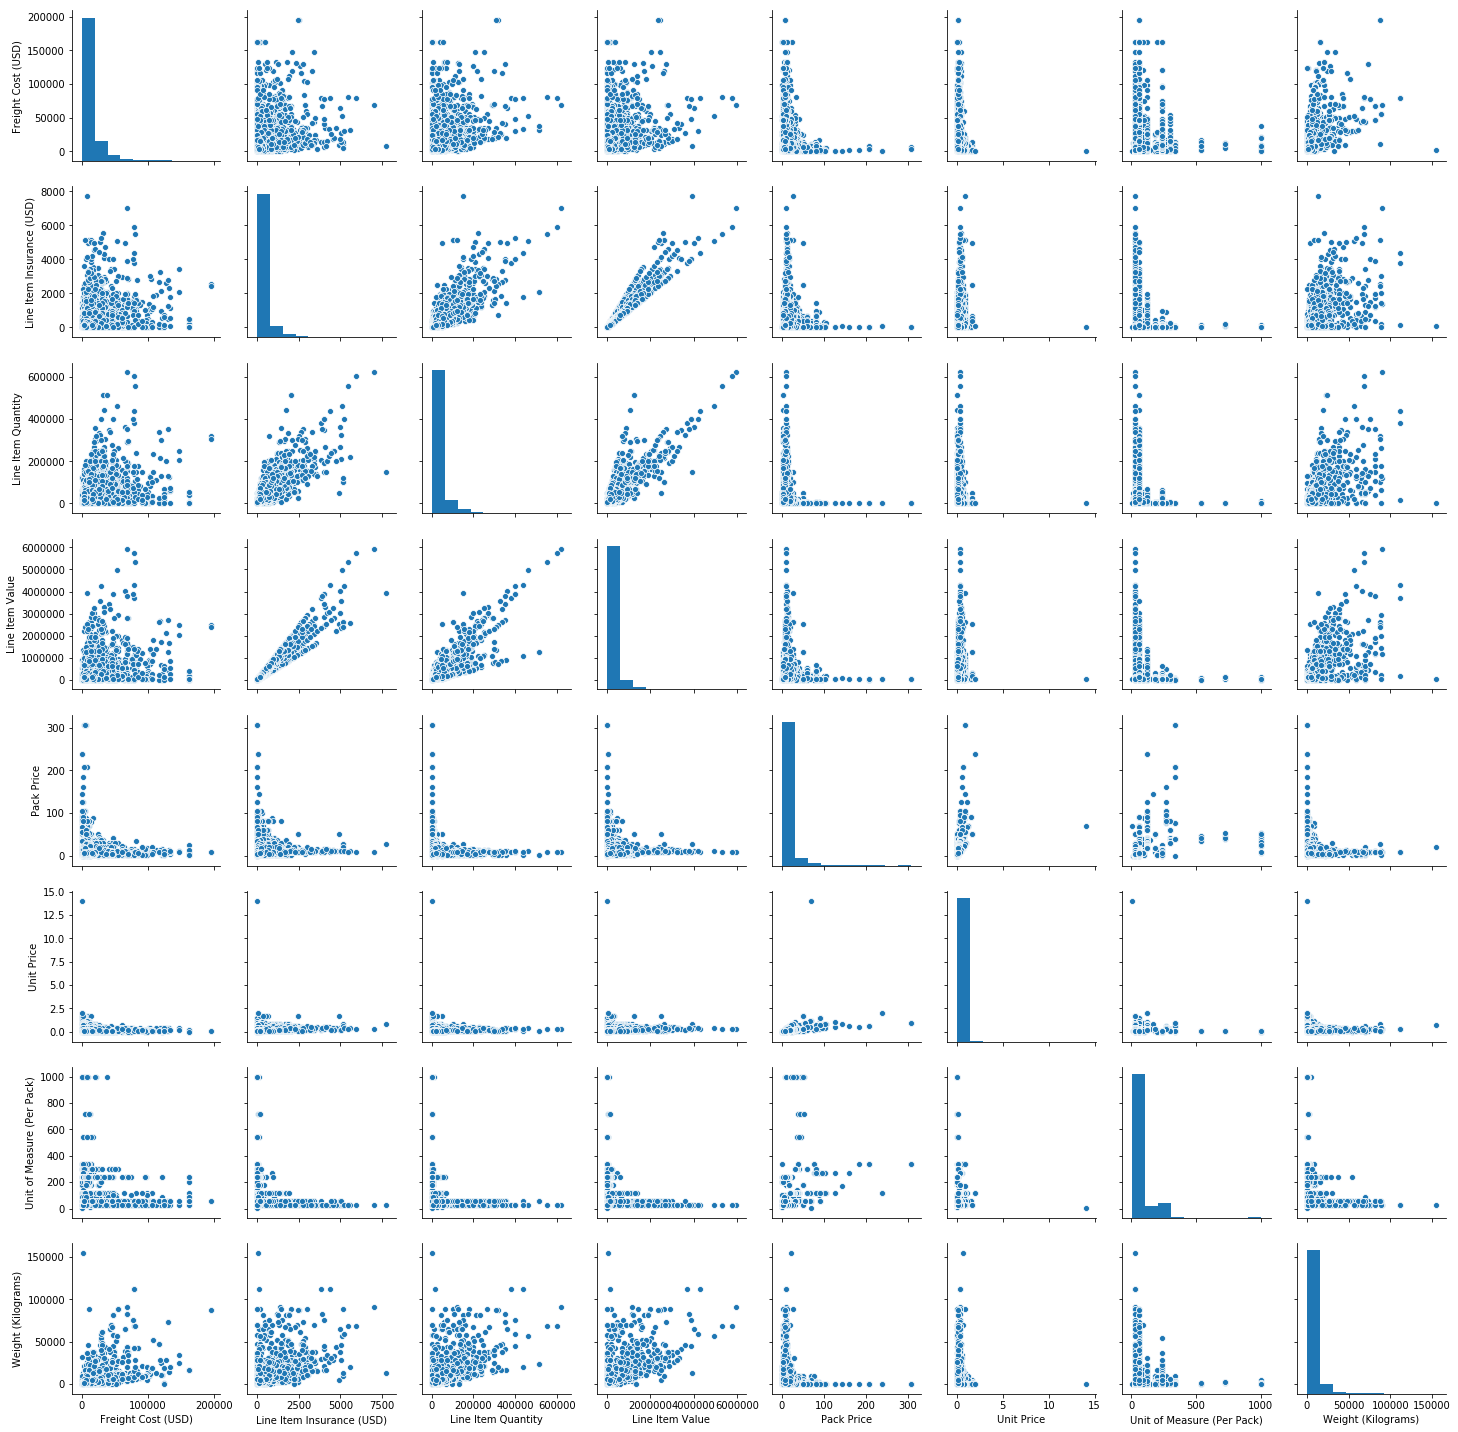

In [23]:
sns.pairplot(data)
plt.show()

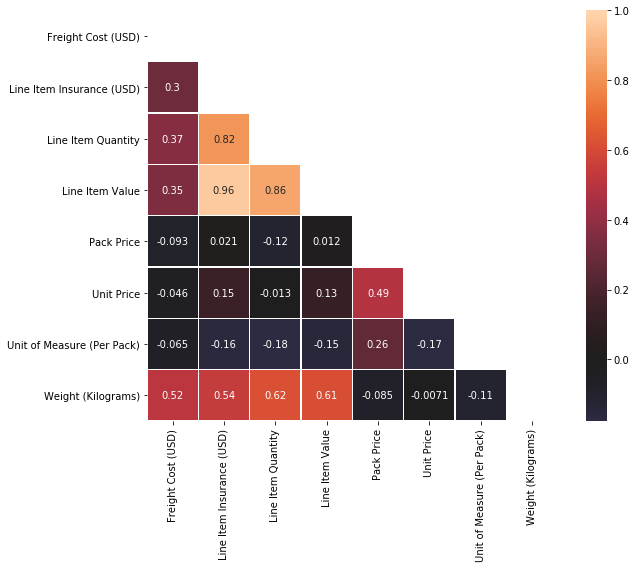

In [24]:
plt.figure(figsize=(10,8))

corr_bp = data.corr()
mask = np.zeros_like(corr_bp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data.corr(), annot=True, mask=mask, center=0, square=True, linewidths=0.5)

plt.tight_layout()
plt.show()

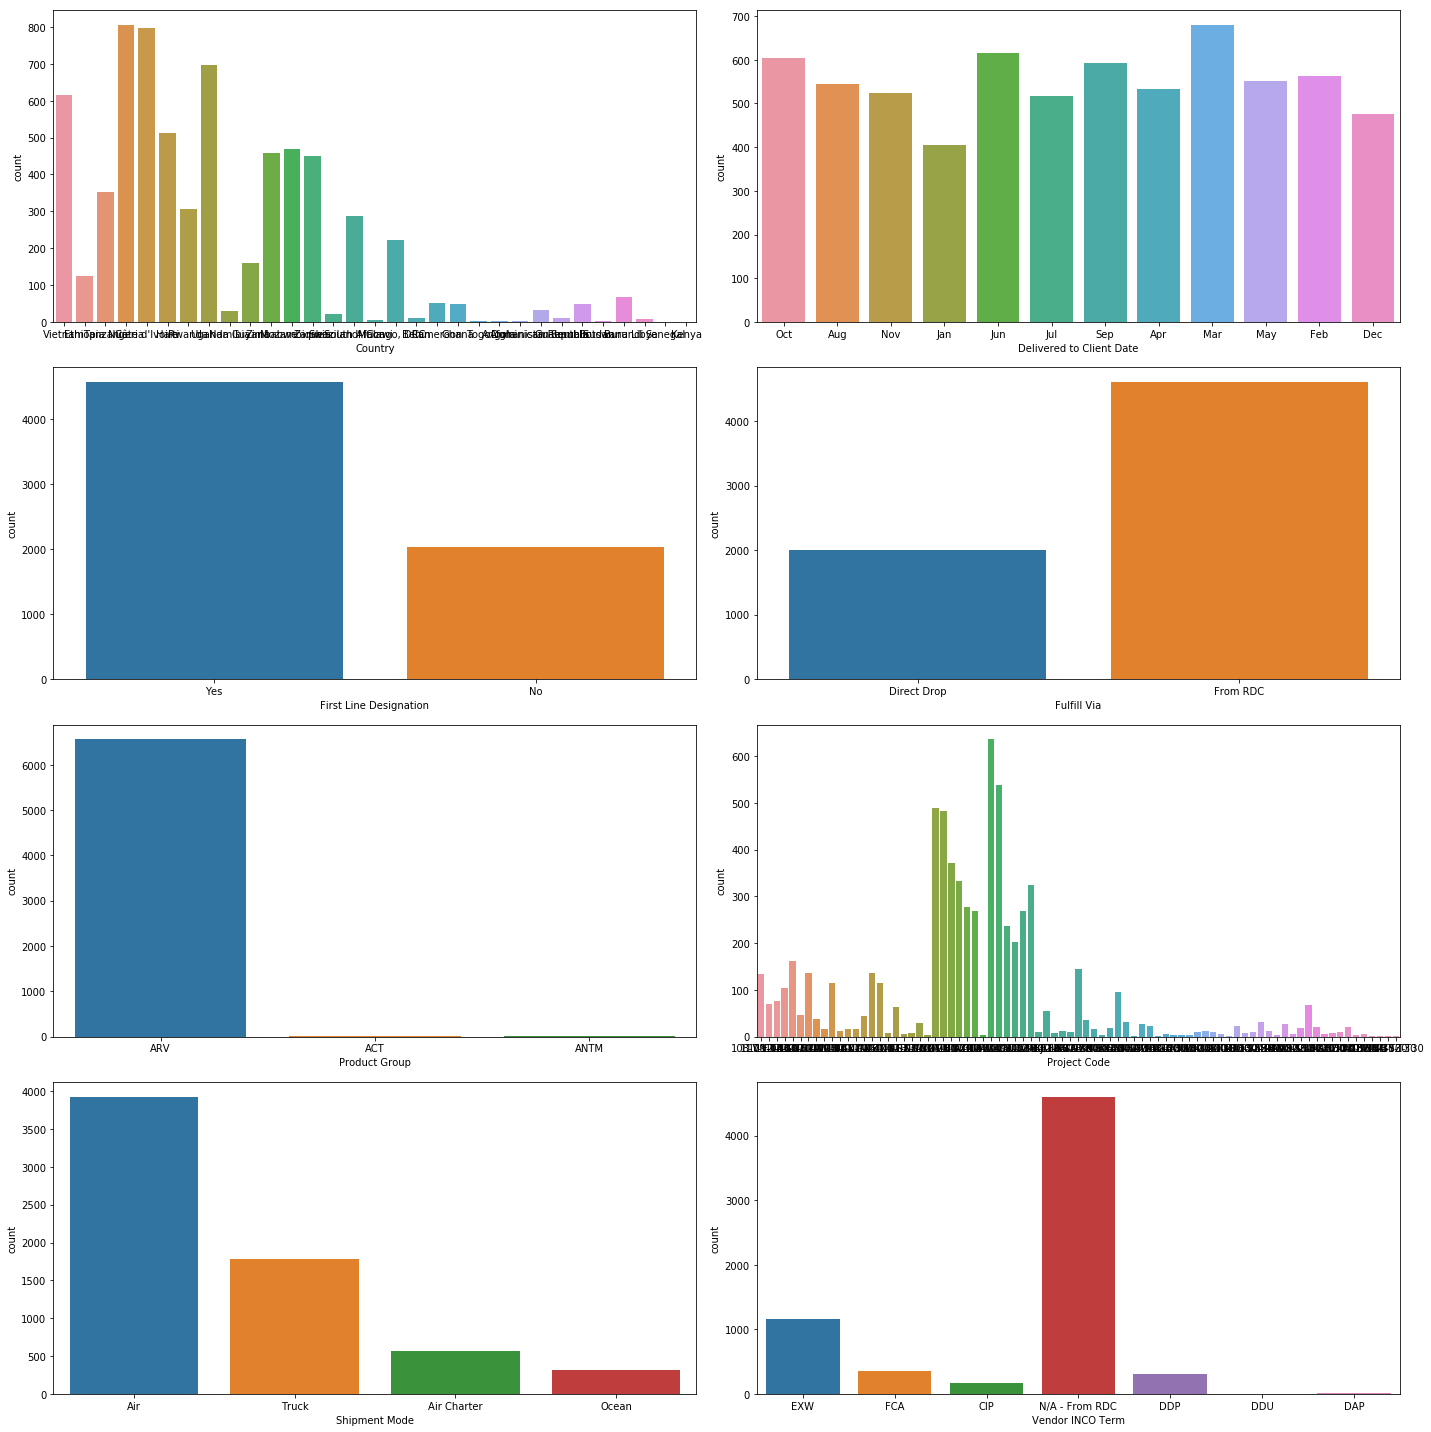

In [25]:
cat_cols=data.select_dtypes('object').columns
fig,axes=plt.subplots(4,2,figsize=(20,20))
axes=axes.flatten()
for i in range(0,len(cat_cols)):
    sns.countplot(data[cat_cols[i]],ax=axes[i])
plt.tight_layout()
plt.show()

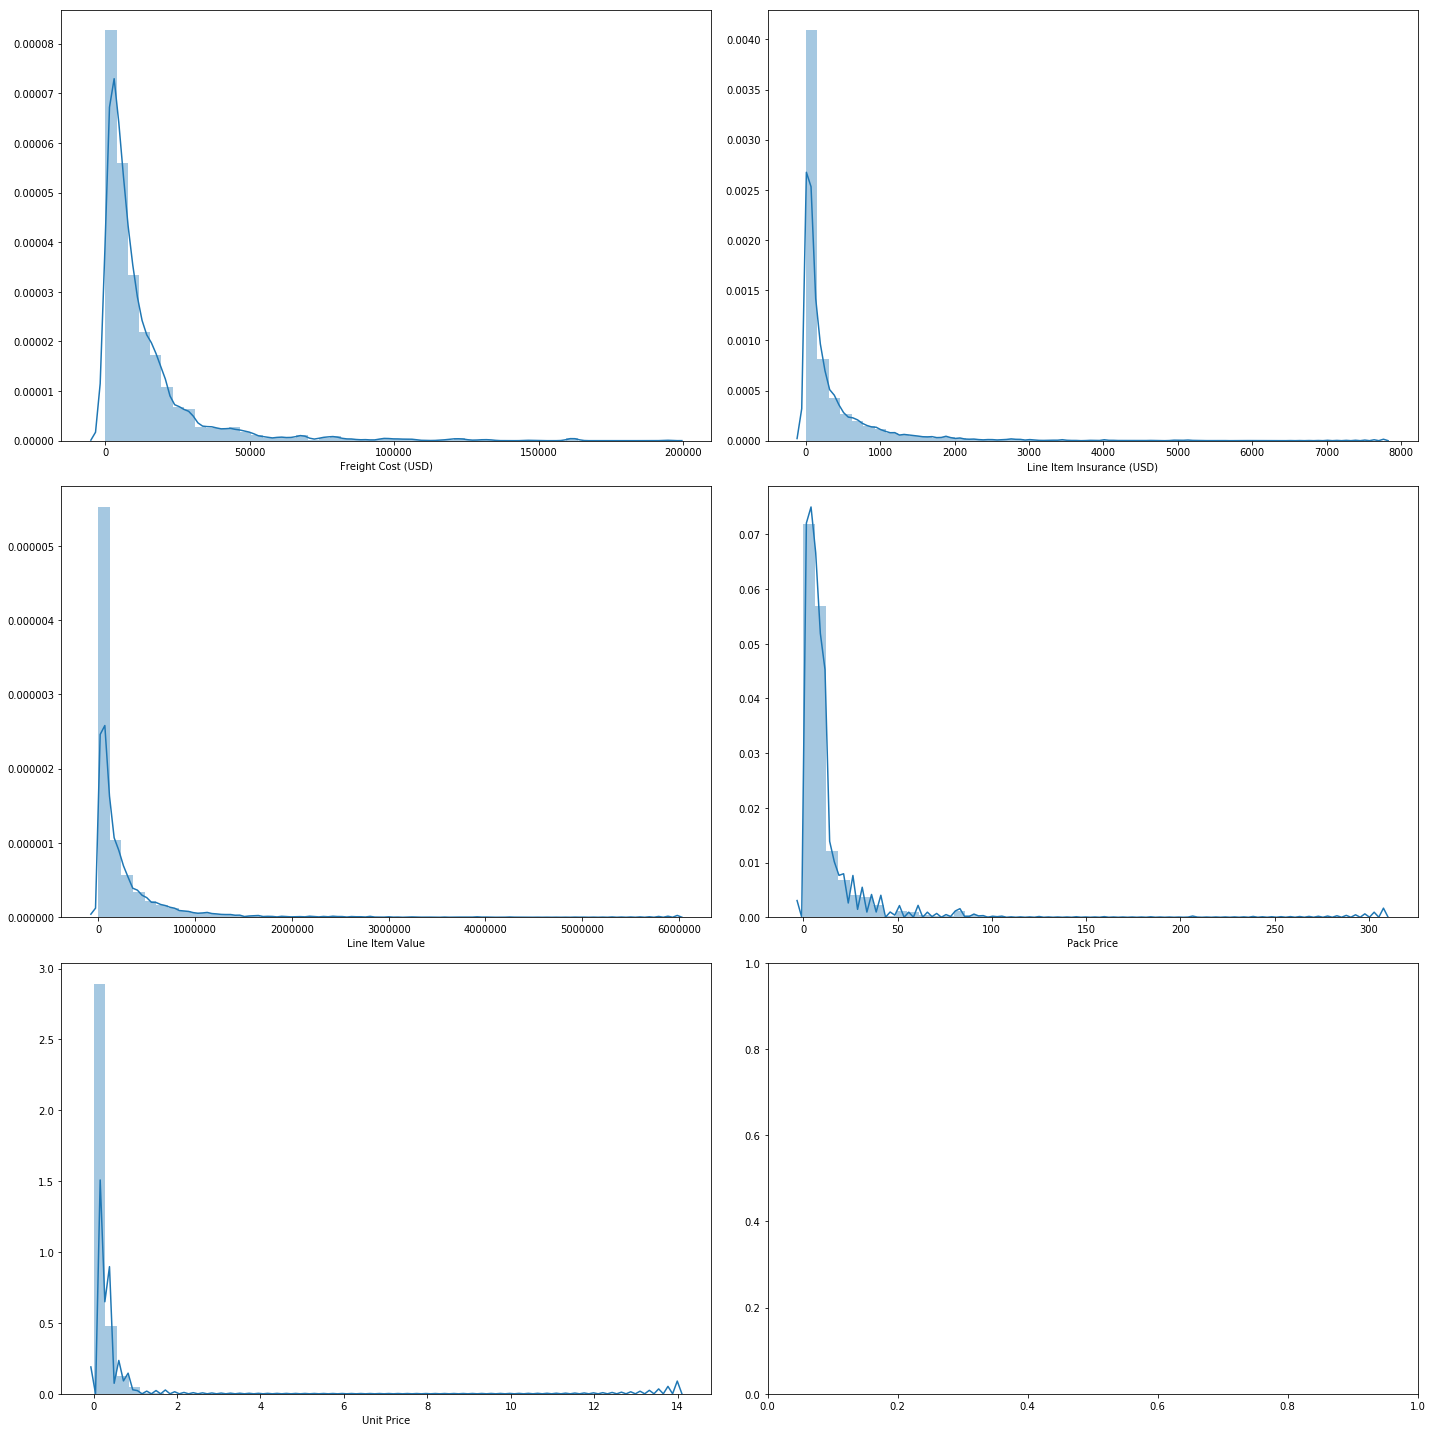

In [26]:
num_cols=data.select_dtypes('float64').columns
fig,axes=plt.subplots(3,2,figsize=(20,20))
axes=axes.flatten()
for i in range(0,len(num_cols)):
    sns.distplot(data[num_cols[i]],ax=axes[i])
plt.tight_layout()
plt.show()

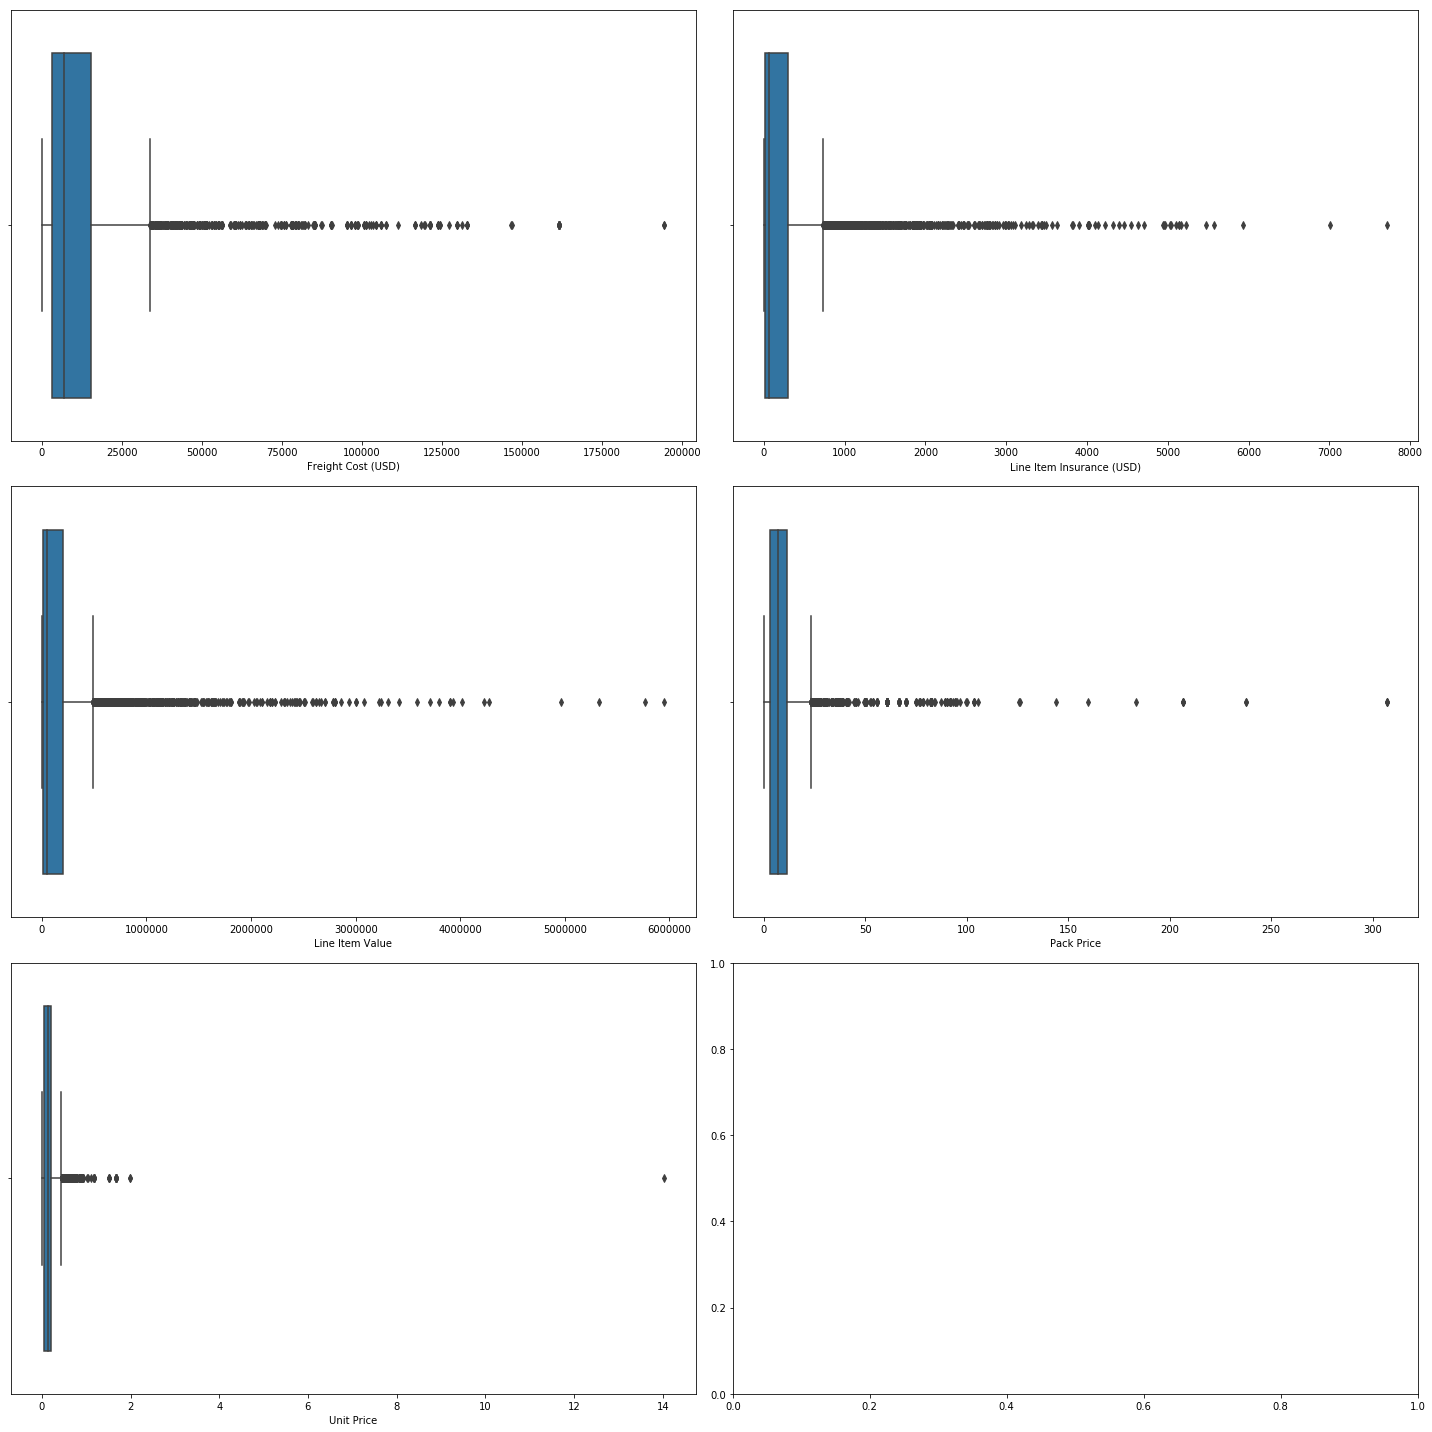

In [27]:
num_cols=data.select_dtypes('float64').columns
fig,axes=plt.subplots(3,2,figsize=(20,20))
axes=axes.flatten()
for i in range(0,len(num_cols)):
    sns.boxplot(data[num_cols[i]],ax=axes[i])
plt.tight_layout()
plt.show()

Total Freight Cost (USD) for Top 15 Countries



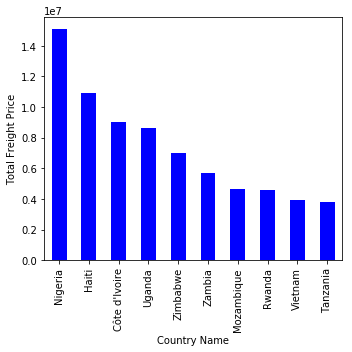

In [28]:
# Top 10 country Freight Cost wise
TotalPrice = data.groupby(['Country'])['Freight Cost (USD)'].sum().nlargest(15)
print("Total Freight Cost (USD) for Top 15 Countries\n")
plt.figure(figsize=(5,5))
GraphData=data.groupby(['Country'])['Freight Cost (USD)'].sum().nlargest(10)
GraphData.plot(kind='bar',color='b')
plt.ylabel('Total Freight Price')
plt.xlabel('Country Name')
plt.tight_layout()
plt.savefig("country")
plt.show()

### Converting Categorical to Dummies

In [29]:
## 
cat_cols = data.select_dtypes(['object']).columns
for col in cat_cols:
    freqs = data[col].value_counts()
    k = freqs.index[freqs>50][:-1]
    for cat in k:
        name = col+'_'+cat
        data[name] = (data[col] == cat).astype(int)
    del data[col]

In [30]:
# Spliting the dataset to test and Train
X = data.drop('Freight Cost (USD)',axis=1)
y = data['Freight Cost (USD)']

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 100)

## Applying Models

### Linear Regression

In [32]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("The Train accuracy is ",model.score(X_train,y_train))
print("The Test Accuracy is ",r2_score(y_test,y_pred))

The Train accuracy is  0.3859210530561801
The Test Accuracy is  0.39325798302960924


###  Decision Tree

In [33]:
dc=DecisionTreeRegressor()
dc.fit(X_train,y_train)
y_pred=dc.predict(X_test)
print("The Train Accuracy Score is",dc.score(X_train,y_train))
print("The Test Accuracy score is", dc.score(X_test,y_test))

The Train Accuracy Score is 0.999997884756651
The Test Accuracy score is 0.5250316769438657


- The model is overfitted

###  Bagging Method

In [34]:
model=BaggingRegressor(tree.DecisionTreeRegressor(random_state=10))
model.fit(X_train,y_train)
print("The Train Accuracy is",model.score(X_train,y_train))
print("The Test Accuracy is ",model.score(X_test,y_test))

The Train Accuracy is 0.9639072607045698
The Test Accuracy is  0.7850540014884861


###  Random Forest

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [8,10,12],
              'max_features': [20,25,30],
             'max_depth': [15,20,25],
             'min_samples_leaf':[25]}
rf = RandomForestRegressor(criterion='mse')
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [8, 10, 12], 'max_features': [20, 25, 30], 'max_depth': [15, 20, 25], 'min_samples_leaf': [25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:
grid_search.best_params_

{'max_depth': 15,
 'max_features': 30,
 'min_samples_leaf': 25,
 'n_estimators': 10}

In [115]:
print("The train Accuracy is ",grid_search.score(X_train,y_train))
print("The test accuracy is",grid_search.score(X_test,y_test))

The train Accuracy is  0.5642448955958179
The test accuracy is 0.522959271765985


In [107]:
rf = RandomForestRegressor(n_estimators=30,max_features=30,max_depth=30,random_state=100)
rf.fit(X_train,y_train)
print("The train Accuracy is ",grid_search.score(X_train,y_train))
print("The accuracy score for Random Forest is",rf.score(X_test,y_test)*100)

The train Accuracy is  0.956581088529549
The accuracy score for Random Forest is 78.28692051956891


### KNN

In [38]:
knn=KNeighborsRegressor()
knn.fit(X_train,y_train)
print("The Train Accuracy is",knn.score(X_train,y_train))
print("The Test Accuracy is",knn.score(X_test,y_test))

The Train Accuracy is 0.49259245867800405
The Test Accuracy is 0.19862048137763355


### Boosting

In [39]:
gda=GradientBoostingRegressor()
gda.fit(X_train,y_train)
print("The Train Accuracy is",gda.score(X_train,y_train))
print("The test Accuracy is",gda.score(X_test,y_test))

The Train Accuracy is 0.7649115944179394
The test Accuracy is 0.6995782189018089


# After Scaling

In [97]:
data2=data.copy()

In [63]:
X=data2.drop('Freight Cost (USD)',axis=1)
y=data['Freight Cost (USD)']

In [71]:
num_cols=X.select_dtypes(['float64','int64']).columns
num_cols

Index(['Line Item Insurance (USD)', 'Line Item Quantity', 'Line Item Value',
       'Pack Price', 'Unit Price', 'Unit of Measure (Per Pack)',
       'Weight (Kilograms)'],
      dtype='object')

In [72]:
sc=StandardScaler()
X[num_cols]=sc.fit_transform(data2[num_cols])

In [88]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=100)

#### Linear Regression

In [89]:
model=LinearRegression()
model.fit(Xtrain,ytrain)
print("The Train Accuracy is",model.score(Xtrain,ytrain))
print("The Test Accuracy is",model.score(Xtest,ytest))

The Train Accuracy is 0.38364247843763644
The Test Accuracy is 0.3923186901686817


#### Decision Tree

In [94]:
dc=DecisionTreeRegressor()
dc.fit(Xtrain,ytrain)
print("The Train Accuracy is ",dc.score(Xtrain,ytrain))
print("The Test Accuracy is",dc.score(Xtest,ytest))

The Train Accuracy is  0.999997884756651
The Test Accuracy is 0.5374977423920478


#### Random Forest

In [96]:
rc=RandomForestRegressor()
rc.fit(Xtrain,ytrain)
print("The Train Accuracy is ",rc.score(Xtrain,ytrain))
print("The Test Accuracy is",rc.score(Xtest,ytest))

The Train Accuracy is  0.9643941912787471
The Test Accuracy is 0.7737633925160688


In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10,15,20],
              'max_features': [5,10,15,20]}
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=2)
grid_search.fit(Xtrain,ytrain)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
print("The train Accuracy is ",grid_search.score(Xtrain,ytrain))
print("The test accuracy is",grid_search.score(Xtest,ytest))

The train Accuracy is  0.9586114617501413
The test accuracy is 0.77145970425832


#### Boosting

In [103]:
gda=GradientBoostingRegressor()
gda.fit(Xtrain,ytrain)
print("The Train Accuracy is",gda.score(Xtrain,ytrain))
print("The test Accuracy is",gda.score(Xtest,ytest))

The Train Accuracy is 0.7649115944179394
The test Accuracy is 0.696834739856989


#### Bagging

In [104]:
model=BaggingRegressor(tree.DecisionTreeRegressor(random_state=10))
model.fit(Xtrain,ytrain)
print("The Train Accuracy is",model.score(Xtrain,ytrain))
print("The Test Accuracy is ",model.score(Xtest,ytest))

The Train Accuracy is 0.9622908642158968
The Test Accuracy is  0.7864264296989469
